In [1]:
import torch
from PIL import Image
import numpy as np
import glob
import yaml
from utils import *
import time
import shutil
import torch.backends.cudnn as cudnn
from test_dataloader import get_loader_test
import pickle
import argparse
from PLIPmodel import Create_PLIP_Model
from visual_model import *
import math
device = "cuda"


/home/toonies/anaconda3/envs/UTE-AI/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PLIPmodel import Create_PLIP_Model


model = Create_PLIP_Model().to(device)
checkpoint = torch.load("checkpoints/PLIP_RN50.pth.tar",map_location='cpu')
model.image_encoder.load_state_dict(checkpoint["ImgEncoder_state_dict"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
des_path =  "data/PLIP_Features/"
paths = "data/KeyFramesC00_V00/"
video_paths = sorted(glob.glob(f"{paths}/*/"))
video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose([
            transforms.Resize((256,128), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize((0.357, 0.323, 0.328),
                                    (0.252, 0.242, 0.239))
])
n = 1
flag = 0
num_n = []
num_mean = []
import time
start_time = time.time()
for vd_path in video_paths:
    print(vd_path)
    re_feats = []
    keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
    keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))
    print("keyframe_paths: ", len(keyframe_paths))
    for keyframe_path in keyframe_paths:
        model = model.eval()
        image = Image.open(keyframe_path).convert('RGB')
        image_trans = transform(image).to(device)
        image_trans = image_trans.unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_feats= model.get_image_embeddings(image_trans)
            
        # image_feats /= image_feats.norm(dim=-1, keepdim=True)
        image_feats = image_feats / (image_feats.norm(dim=1, keepdim=True) + 1e-12)
        image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten()
        
        if flag == 0:
            # print(f"Mean: {image_feats.mean()}")
            num_mean.append(image_feats.mean())
            num_n.append(n)
            n +=1            
            
        re_feats.append(image_feats)

    name_npy = vd_path.split('/')[-1]
    outfile = f'{des_path}/{name_npy}.npy'
    np.save(outfile, re_feats)

print ("Time to extract image features and export npy . file by PLIP: ", time.time() - start_time) 

/home/toonies/anaconda3/envs/UTE-AI/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


data/KeyFramesC00_V00/C00_V0000
keyframe_paths:  1104
data/KeyFramesC00_V00/C00_V0001
keyframe_paths:  1195
Time to extract image features and export npy . file by PLIP:  51.740752935409546


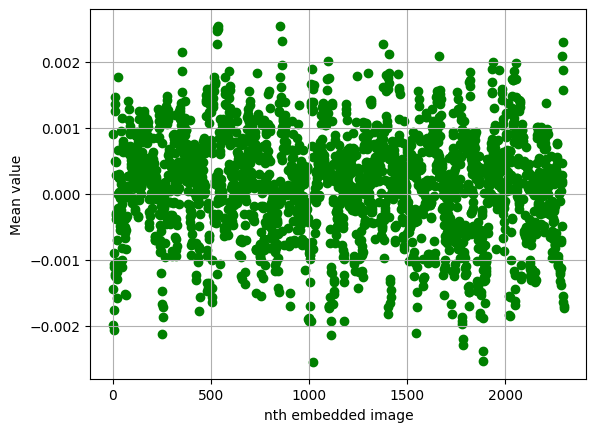

In [26]:
import matplotlib.pyplot as plt

plt.scatter(num_n, num_mean, color='green', marker='o')  # Vẽ các chấm bằng hàm scatter
plt.xlabel('nth embedded image')
plt.ylabel('Mean value')
plt.grid(True)

plt.show()

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
            transforms.Resize((256,128), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize((0.357, 0.323, 0.328),
                                    (0.252, 0.242, 0.239))
])
re_shape = []
for vd_path in video_paths:
    print(vd_path)
    
    re_dirs = []
    re_feats = []
    keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
    keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))
    print("keyframe_paths: ", np.array(keyframe_paths))
    
    
    flag = 0
    for keyframe_path in keyframe_paths:
        model = model.eval()
        image = Image.open(keyframe_path).convert('RGB')
        image_trans = transform(image).to(device)
        image_trans = image_trans.unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_feats= model.get_image_embeddings(image_trans)
            
        # image_feats /= image_feats.norm(dim=-1, keepdim=True)
        image_feats = image_feats / (image_feats.norm(dim=1, keepdim=True) + 1e-12)
        image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten()
        if flag == 0:
            print("Image feats: ", image_feats)
            print("Finish")
            flag = 1
        
        re_dirs.append(np.array(keyframe_path))
        re_feats.append(image_feats)

    re_shape.append(np.array([len(keyframe_paths), image_feats.shape[0]]))

    name_npy = vd_path.split('/')[-1]
    outfile = f'{des_path}/{name_npy}_objects.tsv'
    np.savetxt(outfile, re_feats, delimiter = "\t") 

    outfile_dirs = f'{des_path}/{name_npy}_dirs.tsv'
    np.savetxt(outfile_dirs, re_dirs, delimiter = "\t", fmt = "%s")
    

shape_np = f'{des_path}/shape_arr.tsv'

np.savetxt(shape_np, re_shape, delimiter = "\t",fmt ="%i")

In [45]:
import torchvision.transforms as transforms

transform = transforms.Compose([
            transforms.Resize((256,128), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize((0.357, 0.323, 0.328),
                                    (0.252, 0.242, 0.239))
])
flag = 0
for vd_path in video_paths:
    print(vd_path)
    re_feats = []
    keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
    keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

    for keyframe_path in keyframe_paths:
        model = model.eval()
        image = Image.open(keyframe_path).convert('RGB')
        image_trans = transform(image).to(device)
        image_trans = image_trans.unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_feats= model.get_image_embeddings(image_trans)
            
        # image_feats /= image_feats.norm(dim=-1, keepdim=True)
        image_feats = image_feats / (image_feats.norm(dim=1, keepdim=True) + 1e-12)
        image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten() 
        if flag == 0:
            print("Image feats: ", image_feats.shape)
            flag = 1
        re_feats.append(image_feats)

    name_npy = vd_path.split('/')[-1]
    # outfile = f'{des_path}/{name_npy}.npy'
    # np.save(outfile, re_feats) 

    # re_feats = [[float(np.array(re_feats).shape[0]), "\t", float(np.array(re_feats).shape[1])]] + re_feats
    outfile = f'{des_path}/{name_npy}.tsv'
    print('shape of np: ',np.array(re_feats).shape)
    np.savetxt(outfile, re_feats, delimiter = " ")


/home/toonies/anaconda3/envs/UTE-AI/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


data/KeyFramesC00_V00/C00_V0000
Image feats:  float16
shape of np:  (1104, 768)
data/KeyFramesC00_V00/C00_V0001
shape of np:  (1195, 768)


In [51]:
import numpy as np

re_feats = []
values = np.array([2.7176e-02, -9.2285e-02, -8.0185e-03, 1.0742e-02, -2.6627e-03, -9.6436e-03]).astype(np.float16).flatten()
arr = np.array([2, 3, 5]).astype(np.float16).flatten()
re_feats.append(arr)
re_feats.append(values)
print(re_feats)

[array([2., 3., 5.], dtype=float16), array([ 0.02718 , -0.0923  , -0.00802 ,  0.01074 , -0.002663, -0.00964 ],
      dtype=float16)]
